# Optimizing with CMA-ES in Jax

This notebook shows how to use QDax to find performing parameters on the Rastrigin problem with [CMA-ES](https://arxiv.org/pdf/1604.00772.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a cma-es optimizer
- how to launch a certain number of optimizing steps
- how to visualise the optimization process

In [96]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from qdax.core.cmaes import CMAES

## Set the hyperparameters

In [97]:
#@title Hyperparameters
#@markdown ---
num_iterations = 500 #@param {type:"integer"}
num_dimensions = 20 #100 #1000 #@param {type:"integer"} # try 20 and 100
batch_size = 500 #@param {type:"integer"}
num_best = 250 #@param {type:"integer"}
sigma_g = 5. # 0.5 #@param {type:"number"}
init_step_size = 1. #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
#@markdown ---

## Define the fitness function - choose rastrigin or sphere

In [98]:
def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def sphere_scoring(x: jnp.ndarray):
    return -jnp.sum((x + minval * 0.4) * (x + minval * 0.4), axis=-1)

# fitness_fn = sphere_scoring
fitness_fn = jax.vmap(rastrigin_scoring)

## Define a CMA-ES optimizer instance

In [99]:
cmaes = CMAES(
    population_size=batch_size,
    num_best=num_best,
    search_dim=num_dimensions,
    fitness_function=fitness_fn,
    mean_init=jnp.zeros((num_dimensions,)),
    init_sigma=sigma_g,
    init_step_size=init_step_size,
    delay_eigen_decomposition=True,
)

## Init the CMA-ES optimizer state

In [100]:
state = cmaes.init()
key = jax.random.PRNGKey(0)

## Run optimization iterations

In [101]:
%%time

means = [state.mean]
covs = [state.cov_matrix]
used_samples = []

for _ in range(num_iterations):
    # sample
    samples, key = cmaes.sample(state, key)
    
    # udpate
    state = cmaes.update(state, samples)
    
    # check stop condition
    stop_condition = cmaes.stop_condition(state)

    if stop_condition:
        break
    
    # store data for plotting
    used_samples.append(samples)
    means.append(state.mean)
    covs.append(state.cov_matrix)

CPU times: user 4.84 s, sys: 186 ms, total: 5.03 s
Wall time: 1.89 s


## Check final fitnesses and distribution mean

In [102]:
# checking final fitness values
fitnesses = fitness_fn(samples)

print("Min fitness in the final population: ", jnp.min(fitnesses))
print("Mean fitness in the final population: ", jnp.mean(fitnesses))
print("Max fitness in the final population: ", jnp.max(fitnesses))

# checking mean of the final distribution
print("Final mean of the distribution: \n", means[-1])
# print("Final covariance matrix of the distribution: ", covs[-1])

Min fitness in the final population:  -3.426056
Mean fitness in the final population:  -3.1772869
Max fitness in the final population:  -3.039917
Final mean of the distribution: 
 [2.0482876 2.0476012 2.0472763 1.0519729 1.0526433 2.0488436 2.0477805
 2.047933  2.0474577 2.0468817 2.0489116 2.0487678 2.0483027 2.0474896
 2.048296  2.0484762 2.0482798 2.047545  2.0476801 3.0432663]


## Visualization of the optimization trajectory

<IPython.core.display.Javascript object>


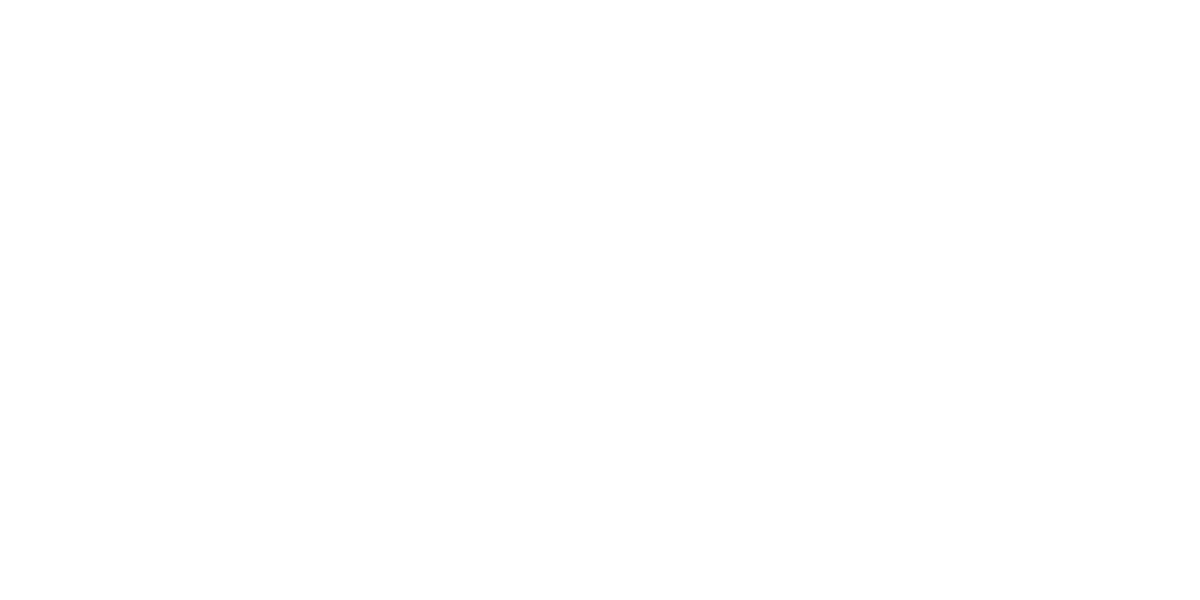

In [103]:
fig, ax = plt.subplots(figsize=(12, 6))

# sample points to show fitness landscape
x = jax.random.uniform(key, minval=-4, maxval=8, shape=(100000, 2))
f_x = fitness_fn(x)

# plot fitness landscape
points = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=0.1)
fig.colorbar(points)

# plot cma-es trajectory
traj_min = 0
traj_max = 500
for mean, cov in zip(means[traj_min:traj_max], covs[traj_min:traj_max]):
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
    ax.add_patch(ellipse)
    ax.plot(mean[0], mean[1], color='k', marker='x')
    
ax.set_title(f"Optimization trajectory of CMA-ES between step {traj_min} and step {traj_max}")
plt.show()

## Trying dynamic visualisation tool

In [104]:
# Import animation package
from matplotlib.animation import FuncAnimation

In [105]:
# Change matplotlib backend
%matplotlib notebook

<IPython.core.display.Javascript object>


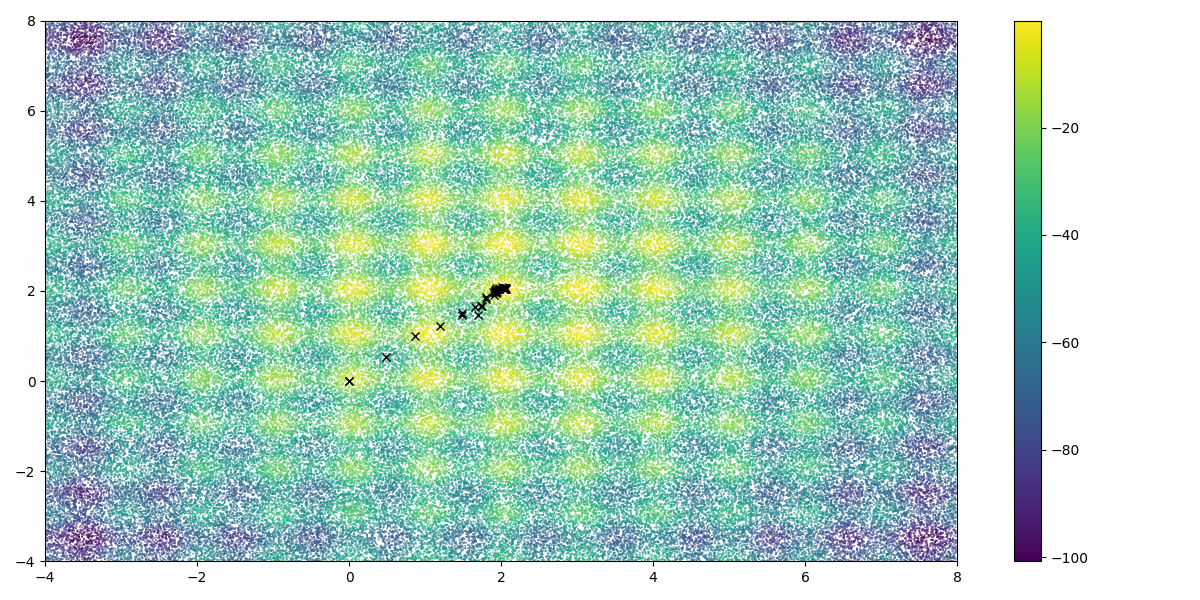

In [106]:
# fig, ax = plt.subplots(figsize=(12, 6))
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

# Create variable reference to plot
# f_d, = ax.plot([], [], linewidth=2.5)

# sample points to show fitness landscape
x = jax.random.uniform(key, minval=-4, maxval=8, shape=(200000, 2))
f_x = fitness_fn(x)

# plot fitness landscape
plot1 = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=0.1)
fig.colorbar(plot1)

# adding sampled points
plot2 = ax.scatter([], [], s=1, c="r")

mean = means[0]
cov = covs[0]
ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')

ax.add_patch(ellipse)

def frame_plot(i):
    # get data
    mean = means[i]
    cov = covs[i]
    sample_i = used_samples[i]
    # prepare plot
#     ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
    ellipse.set_center((mean[0], mean[1]))
    ellipse.width = cov[0, 0]
    ellipse.height = cov[1, 1]
#     ellipse.update_from(
#         Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
#     )
    
    # add points
    plot2.set_offsets(sample_i[:, 0:2])
#     ax.scatter(sample_i[:, 0], sample_i[:, 1], s=1)
    
#     ax.add_patch(ellipse)
    ax.plot(mean[0], mean[1], color='k', marker='x')


# plot cma-es trajectory
traj_min = 0
traj_max = 500

my_frames = range(traj_min, traj_max)

dynamic_plot = FuncAnimation(fig=fig, func=frame_plot, frames=my_frames, interval=1000, repeat=True)
    
# ax.set_title(f"Optimization trajectory of CMA-ES between step {traj_min} and step {traj_max}")
plt.xlim([-4, 8])
plt.ylim([-4, 8])

fig.tight_layout()

plt.show()

In [ ]:
# Save and show animation
dynamic_plot.save('AnimatedPlot.gif', writer='imagemagick', fps=2)